In [4]:
#some libraries are not used; may delete those unused in this script
import pandas as pd
import numpy as np
import glob
import os
import sys
import xgboost #install xgboost: https://xgboost.readthedocs.io/en/latest/index.html#
import sklearn
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
import pickle 
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import shap #install shap: https://github.com/slundberg/shap 

In [5]:
#demo with CADD scores:
#files needed: CADD_input.csv.gz, 1000G_final.vcf.gz, baselineLD_allchr.annot.gz (download from https://alkesgroup.broadinstitute.org/LDSCORE/Kim_annotboost/)

In [6]:
features = ['Coding_UCSC', 'Coding_UCSC.extend.500',
       'Conserved_LindbladToh', 'Conserved_LindbladToh.extend.500',
       'CTCF_Hoffman', 'CTCF_Hoffman.extend.500', 'DGF_ENCODE',
       'DGF_ENCODE.extend.500', 'DHS_peaks_Trynka', 'DHS_Trynka',
       'DHS_Trynka.extend.500', 'Enhancer_Andersson',
       'Enhancer_Andersson.extend.500', 'Enhancer_Hoffman',
       'Enhancer_Hoffman.extend.500', 'FetalDHS_Trynka',
       'FetalDHS_Trynka.extend.500', 'H3K27ac_Hnisz',
       'H3K27ac_Hnisz.extend.500', 'H3K27ac_PGC2', 'H3K27ac_PGC2.extend.500',
       'H3K4me1_peaks_Trynka', 'H3K4me1_Trynka', 'H3K4me1_Trynka.extend.500',
       'H3K4me3_peaks_Trynka', 'H3K4me3_Trynka', 'H3K4me3_Trynka.extend.500',
       'H3K9ac_peaks_Trynka', 'H3K9ac_Trynka', 'H3K9ac_Trynka.extend.500',
       'Intron_UCSC', 'Intron_UCSC.extend.500', 'PromoterFlanking_Hoffman',
       'PromoterFlanking_Hoffman.extend.500', 'Promoter_UCSC',
       'Promoter_UCSC.extend.500', 'Repressed_Hoffman',
       'Repressed_Hoffman.extend.500', 'SuperEnhancer_Hnisz',
       'SuperEnhancer_Hnisz.extend.500', 'TFBS_ENCODE',
       'TFBS_ENCODE.extend.500', 'Transcr_Hoffman',
       'Transcr_Hoffman.extend.500', 'TSS_Hoffman', 'TSS_Hoffman.extend.500',
       'UTR_3_UCSC', 'UTR_3_UCSC.extend.500', 'UTR_5_UCSC',
       'UTR_5_UCSC.extend.500', 'WeakEnhancer_Hoffman',
       'WeakEnhancer_Hoffman.extend.500', 'GERP.NS', 'GERP.RSsup4', 'MAFbin1',
       'MAFbin2', 'MAFbin3', 'MAFbin4', 'MAFbin5', 'MAFbin6', 'MAFbin7',
       'MAFbin8', 'MAFbin9', 'MAFbin10', 'MAF_Adj_Predicted_Allele_Age',
       'MAF_Adj_LLD_AFR', 'Recomb_Rate_10kb', 'Nucleotide_Diversity_10kb',
       'Backgrd_Selection_Stat', 'CpG_Content_50kb', 'MAF_Adj_ASMC',
       'GTEx_eQTL_MaxCPP', 'BLUEPRINT_H3K27acQTL_MaxCPP',
       'BLUEPRINT_H3K4me1QTL_MaxCPP', 'BLUEPRINT_DNA_methylation_MaxCPP',
       'synonymous', 'non_synonymous', 'Conserved_Vertebrate_phastCons46way',
       'Conserved_Vertebrate_phastCons46way.extend.500',
       'Conserved_Mammal_phastCons46way',
       'Conserved_Mammal_phastCons46way.extend.500',
       'Conserved_Primate_phastCons46way',
       'Conserved_Primate_phastCons46way.extend.500', 'BivFlnk',
       'BivFlnk.extend.500'] #85 features from baseline-LD (v.2.1)

In [7]:
'''
input: input_patho_score full directory
Need two columns: "SNP" and "SCORE"
If you have genomic regions, not SNP, merge with CADD.csv.gz (provided) that have 9997231 1000G common+low-freq SNPs.
see the example: /annotboost/AnnotBoost_sourcecode/reference_files_demo/input/CADD.csv.gz
SNP: RSID, and Y are pathogenicity scores (higher more pathogenic)
if the original score indicates lower more pathogenic, reverse the score (e.g. 1/original score)
'''
def prepare_data(input_patho_score, evenodd):
	df = pd.read_csv("%s/baselineLD_allchr.annot.gz" %args.basedir,sep="\t")
	all = df.drop(["BP", "CM", "base"],axis=1)
	del df
	score = pd.read_csv("%s/%s" %(args.basedir,input_patho_score)) 
	rf = pd.read_csv("%s/1000G_final.vcf.gz" %args.basedir, names=["CHR","BP","SNP","REF","ALT"])
	score = score.merge(rf, on=["CHR","BP","REF","ALT"]) #if window-based, remove REF, ALT here
	all["Y"] = -1
	all.loc[all.SNP.isin(score[score.SCORE >= score.SCORE.quantile(0.9)].SNP.to_list()), "Y"] = 1 #top 10% indicate as Y = 1
	all.loc[all.SNP.isin(score[score.SCORE < score.SCORE.quantile(0.4)].SNP.to_list()), "Y"] = 0 #bottom 40% indicate as Y = 0
	all = all[all.Y != -1] #drop SNPs with no labels
	#all.to_csv("%s/training_matrix_%s.csv.gz" %(args.basedir,args.published_score_filename), index=False, compression='gzip') #SNP + CHR + features + 'Y'
	if evenodd == 'even': #using even chromosome data
		all = all[all.CHR % 2 == 0]
	else: #odd chr
		all = all[all.CHR % 2 == 1]
	Y_train = all.Y.values
	X_train = all[features].values
	del all
	return X_train, Y_train 

In [8]:
'''          
if computational time is limited, change n_iter to 5 or less.
these parameters are what has been used in the manuscript.
Optimize as needed, based on your data: suggest not changing gamma and learning rate.
'''
def fit_model(x_train,y_train,n_iter=10,cv=5):
    n_estimators = [200, 250, 300]
    max_depth = [25, 30, 35]
    learning_rate = [0.05] #0.05 fixed to avoid over-fitting
    gamma = [10]
    one_to_left = st.beta(10, 1)
    min_child_weight = [6, 8, 10]
    from_zero_positive = st.expon(0, 50)
    nthread = [1]
    scale_pos_weight = [1, 2, 3, 4, 5]
    subsample = [0.6, 0.8, 1]
    random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
                'learning_rate':learning_rate,
                "colsample_bytree": one_to_left,
                "subsample": subsample,
                'reg_alpha': from_zero_positive,
                "min_child_weight": min_child_weight,
                'gamma':gamma,
                'nthread':nthread,
                'scale_pos_weight':scale_pos_weight}
    xgb_tune = xgboost.XGBClassifier(missing=np.nan)
    xgb_hyper = RandomizedSearchCV(xgb_tune,random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = -1,scoring='roc_auc') 
    xgb_hyper.fit(x_train, y_train)
    return xgb_hyper.best_estimator_ #return the best model based on scoring=roc_auc

In [9]:
#make predictions, ROC/PR curve plot
def test_model(xgb_mod,x_test,y_test,df,evenodd):
    predictions_all = xgb_mod.predict_proba(x_test)[:,1]
    df = df[df.Y != -1] #for ROC/PR curves, use only labeled SNPs
    predictions = xgb_mod.predict_proba(df[features].values)[:,1]
    y_test = df["Y"].values
    ROC_curve(predictions,y_test, evenodd)
    PR_curve(predictions,y_test, evenodd) 
    return predictions_all
   
#plot ROC curve 
#y_pred is the probabilistic score after applying AnnotBoost
#y_test is binarized label used in the training
def ROC_curve(y_pred, y_test, evenodd):
    tilte = "ROC curve"
    label = "baseline-LD features"
    y = np.asarray(y_test).reshape((len(y_test),1))
    y_hat = np.asarray(y_pred).reshape((len(y_pred),1))
    fpr, tpr, _ = roc_curve(y,y_hat)
    AUROC = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=label + ' (AUC = %.3f)' % AUROC)
    plt.legend(loc='lower right')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.savefig('%s/ROC_CURVE_%s_%s.png' %(args.basedir, args.published_score_filename, evenodd))
    plt.close()
    return

#plot PR curve
#y_pred is the probabilistic score after applying AnnotBoost
#y_test is binarized label used in the training
def PR_curve(y_pred, y_test, evenodd):
    tilte = "PR curve"
    label = "baseline-LD features"
    y = np.asarray(y_test).reshape((len(y_test),1))
    y_hat = np.asarray(y_pred).reshape((len(y_pred),1))
    precision, recall, thresholds = precision_recall_curve(y, y_hat)
    AUPR = average_precision_score(y,y_hat)
    plt.plot(recall,precision,label=label + ' (AP = %.3f)' % AUPR, color='r')
    plt.legend(loc='lower left')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.savefig('%s/PR_CURVE_%s_%s.png' %(args.basedir, args.published_score_filename, evenodd))
    plt.close()
    return

In [10]:
def SHAP_feature_importance(model, X, Y, evenodd, approximate=False):
	explainer = shap.TreeExplainer(model)		
	shap_values = explainer.shap_values(X, Y, approximate)
	shap.summary_plot(shap_values, X, plot_type="bar", show=False)                                                                  
	plt.savefig("%s/SHAP_featurerank_%s_%s.png" %(args.basedir, args.published_score_filename, evenodd), dpi=300, bbox_inches = "tight")
	plt.clf()  
	plt.close()
	shap.summary_plot(shap_values, X, show=False)
	plt.savefig("%s/SHAP_signedsummary_%s_%s.png" %(args.basedir, args.published_score_filename, evenodd), dpi=300, bbox_inches = "tight")
	plt.clf()
	plt.close()  
	return

In [11]:
'''
make annotation files (.annot.gz) from genome-wide prediction or published scores
these annotations are used in S-LDSC analysis
top 10%-top0.1% by default (top X% can be optimized based on S-LDSC tau*)
annotations use 1000G EUR phase3 as a reference panel. If other reference panel is desired, use your template annot.gz files.
S-LDSC script (annotations as input) is provided in https://github.com/samskim/networkconnectivity
'''
def prediction_to_annot(result_csv, outfilename, SCORE):
	tf = pd.read_csv("%s/RESULT_%s" %(args.basedir, result_csv)) #assume that annotations are created after running AnnotBoost and predictions are made
	tf0 = tf[(tf[SCORE] >= tf[SCORE].quantile(0.90))] #top 10% SNPs
	tf1 = tf[(tf[SCORE] >= tf[SCORE].quantile(0.95))]
	tf2 = tf[(tf[SCORE] >= tf[SCORE].quantile(0.99))]
	tf3 = tf[(tf[SCORE] >= tf[SCORE].quantile(0.995))]
	tf4 = tf[(tf[SCORE] >= tf[SCORE].quantile(0.999))] #top 0.1% SNPs
	if SCORE == 'SCORE':
		pubbos = "published"
	else:
		pubbos = "boosted"
	for j in range(1,23):
			df = pd.read_csv("%s/example_annotations/example.%s.annot.gz" %(args.basedir, j), sep="\t")
			df = df.drop("SAM_ANNOT",axis=1)
			df["ANNOT"] = 0
			df.loc[df.SNP.isin(tf0.SNP), ['ANNOT']] = 1
			af = df[["ANNOT"]]
			af.to_csv("%s/%s_%s.perc90.%s.annot.gz" %(args.basedir,outfilename,pubbos,j), compression='gzip', index=False)
			df["ANNOT"] = 0
			df.loc[df.SNP.isin(tf1.SNP), ['ANNOT']] = 1
			af = df[["ANNOT"]]
			af.to_csv("%s/%s_%s.perc95.%s.annot.gz" %(args.basedir,outfilename,pubbos,j), compression='gzip', index=False)
			df["ANNOT"] = 0
			df.loc[df.SNP.isin(tf2.SNP), ['ANNOT']] = 1
			af = df[["ANNOT"]]
			af.to_csv("%s/%s_%s.perc99.%s.annot.gz" %(args.basedir,outfilename,pubbos,j), compression='gzip', index=False)
			df["ANNOT"] = 0
			df.loc[df.SNP.isin(tf3.SNP), ['ANNOT']] = 1
			af = df[["ANNOT"]]
			af.to_csv("%s/%s_%s.perc995.%s.annot.gz" %(args.basedir,outfilename,pubbos,j), compression='gzip', index=False)
			df["ANNOT"] = 0
			df.loc[df.SNP.isin(tf4.SNP), ['ANNOT']] = 1
			af = df[["ANNOT"]]
			af.to_csv("%s/%s_%s.perc999.%s.annot.gz" %(args.basedir,outfilename,pubbos,j), compression='gzip', index=False)
	return

In [12]:
import easydict
args = easydict.EasyDict({
    "mode": 'training',
    "basedir": '/n/groups/price/tier2/sam/annotboost_upload/annotboost/AnnotBoost_sourcecode/reference_files_demo/reference_files/annotboost/',
    "published_score_filename": 'CADD_input.csv.gz',
    "debug": 'T'
})

In [13]:
print("Training in progress using even chromosome SNPs!")
x_train, y_train = prepare_data(args.published_score_filename, "even")
if args.debug == 'T':
	x_train = x_train[0:1000]
	y_train = y_train[0:1000]
np.random.seed(1)

Training in progress using even chromosome SNPs!


In [14]:
print (x_train)
print (y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

In [18]:
print("reading input score and appending with the feature matrix completed!")
xgb_best = fit_model(x_train,y_train)
print("training completed!")
print ("writing the model")
with open("%s/%s:even.pickle" %(args.basedir, args.published_score_filename),'wb') as fp:
	pickle.dump(xgb_best,fp)
	print ("xgboost: training model written in /%s" %args.basedir)
X_df = pd.DataFrame(x_train)
X_df.columns = features
SHAP_feature_importance(xgb_best, X_df, y_train, "even",  approximate=False) #measure unbiased feature importance using SHAP
print ("SHAP feature importance written!")

reading input score and appending with the feature matrix completed!
training completed!
writing the model
xgboost: training model written in //n/groups/price/tier2/sam/annotboost_upload/annotboost/AnnotBoost_sourcecode/reference_files_demo/reference_files/annotboost/


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


SHAP feature importance written!


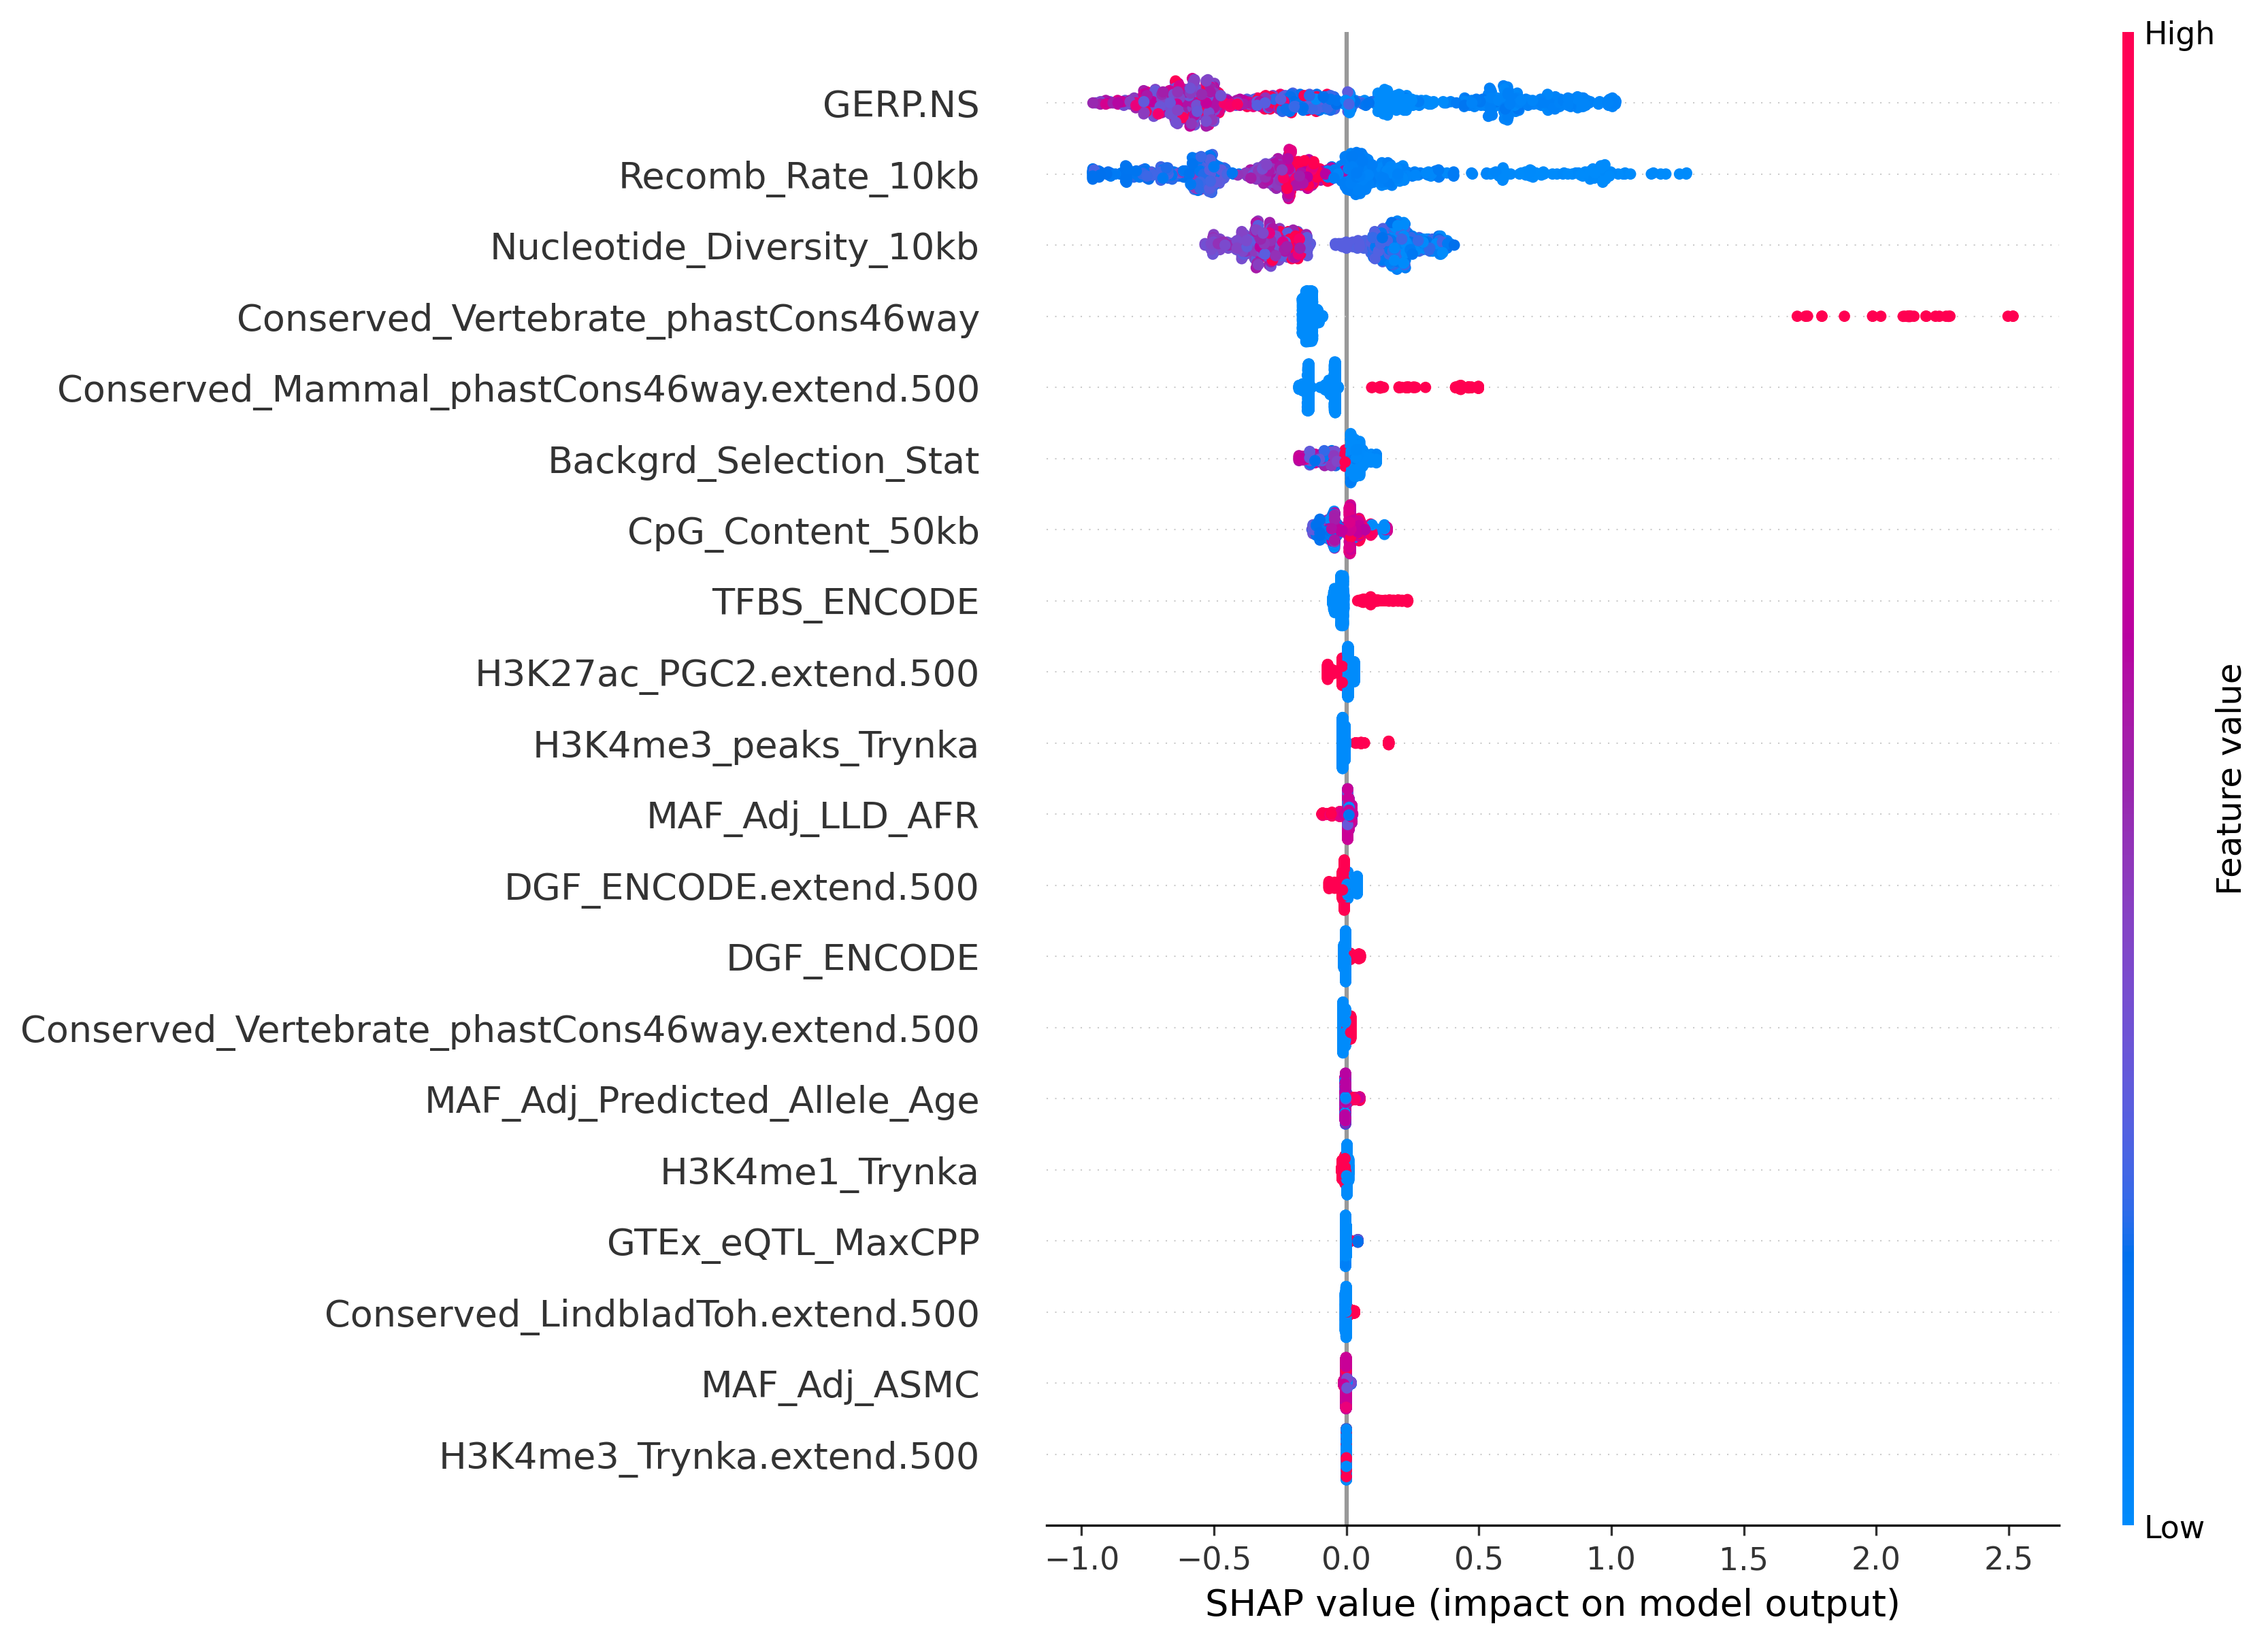

In [19]:
xgb_best
from IPython.display import Image
Image(filename='%s/SHAP_signedsummary_CADD_input.csv.gz_even.png' %args.basedir) 

In [20]:
print("Training in progress using odd chromosome SNPs!")
x_train, y_train = prepare_data(args.published_score_filename, "odd")
if args.debug == 'T':
	x_train = x_train[0:1000]
	y_train = y_train[0:1000]
print("reading input score and appending with the feature matrix completed!")
xgb_best = fit_model(x_train,y_train)
print("training completed!")
print ("writing the model")
with open("%s/%s:odd.pickle" %(args.basedir, args.published_score_filename),'wb') as fp:
	pickle.dump(xgb_best,fp)
	print ("xgboost: training model written in /%s" %args.basedir)
X_df = pd.DataFrame(x_train)
X_df.columns = features
SHAP_feature_importance(xgb_best, X_df, y_train, "odd",  approximate=False) 
print ("SHAP feature importance written!")
print ("Training completed!")

Training in progress using odd chromosome SNPs!
reading input score and appending with the feature matrix completed!
training completed!
writing the model
xgboost: training model written in //n/groups/price/tier2/sam/annotboost_upload/annotboost/AnnotBoost_sourcecode/reference_files_demo/reference_files/annotboost/


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


SHAP feature importance written!
Training completed!


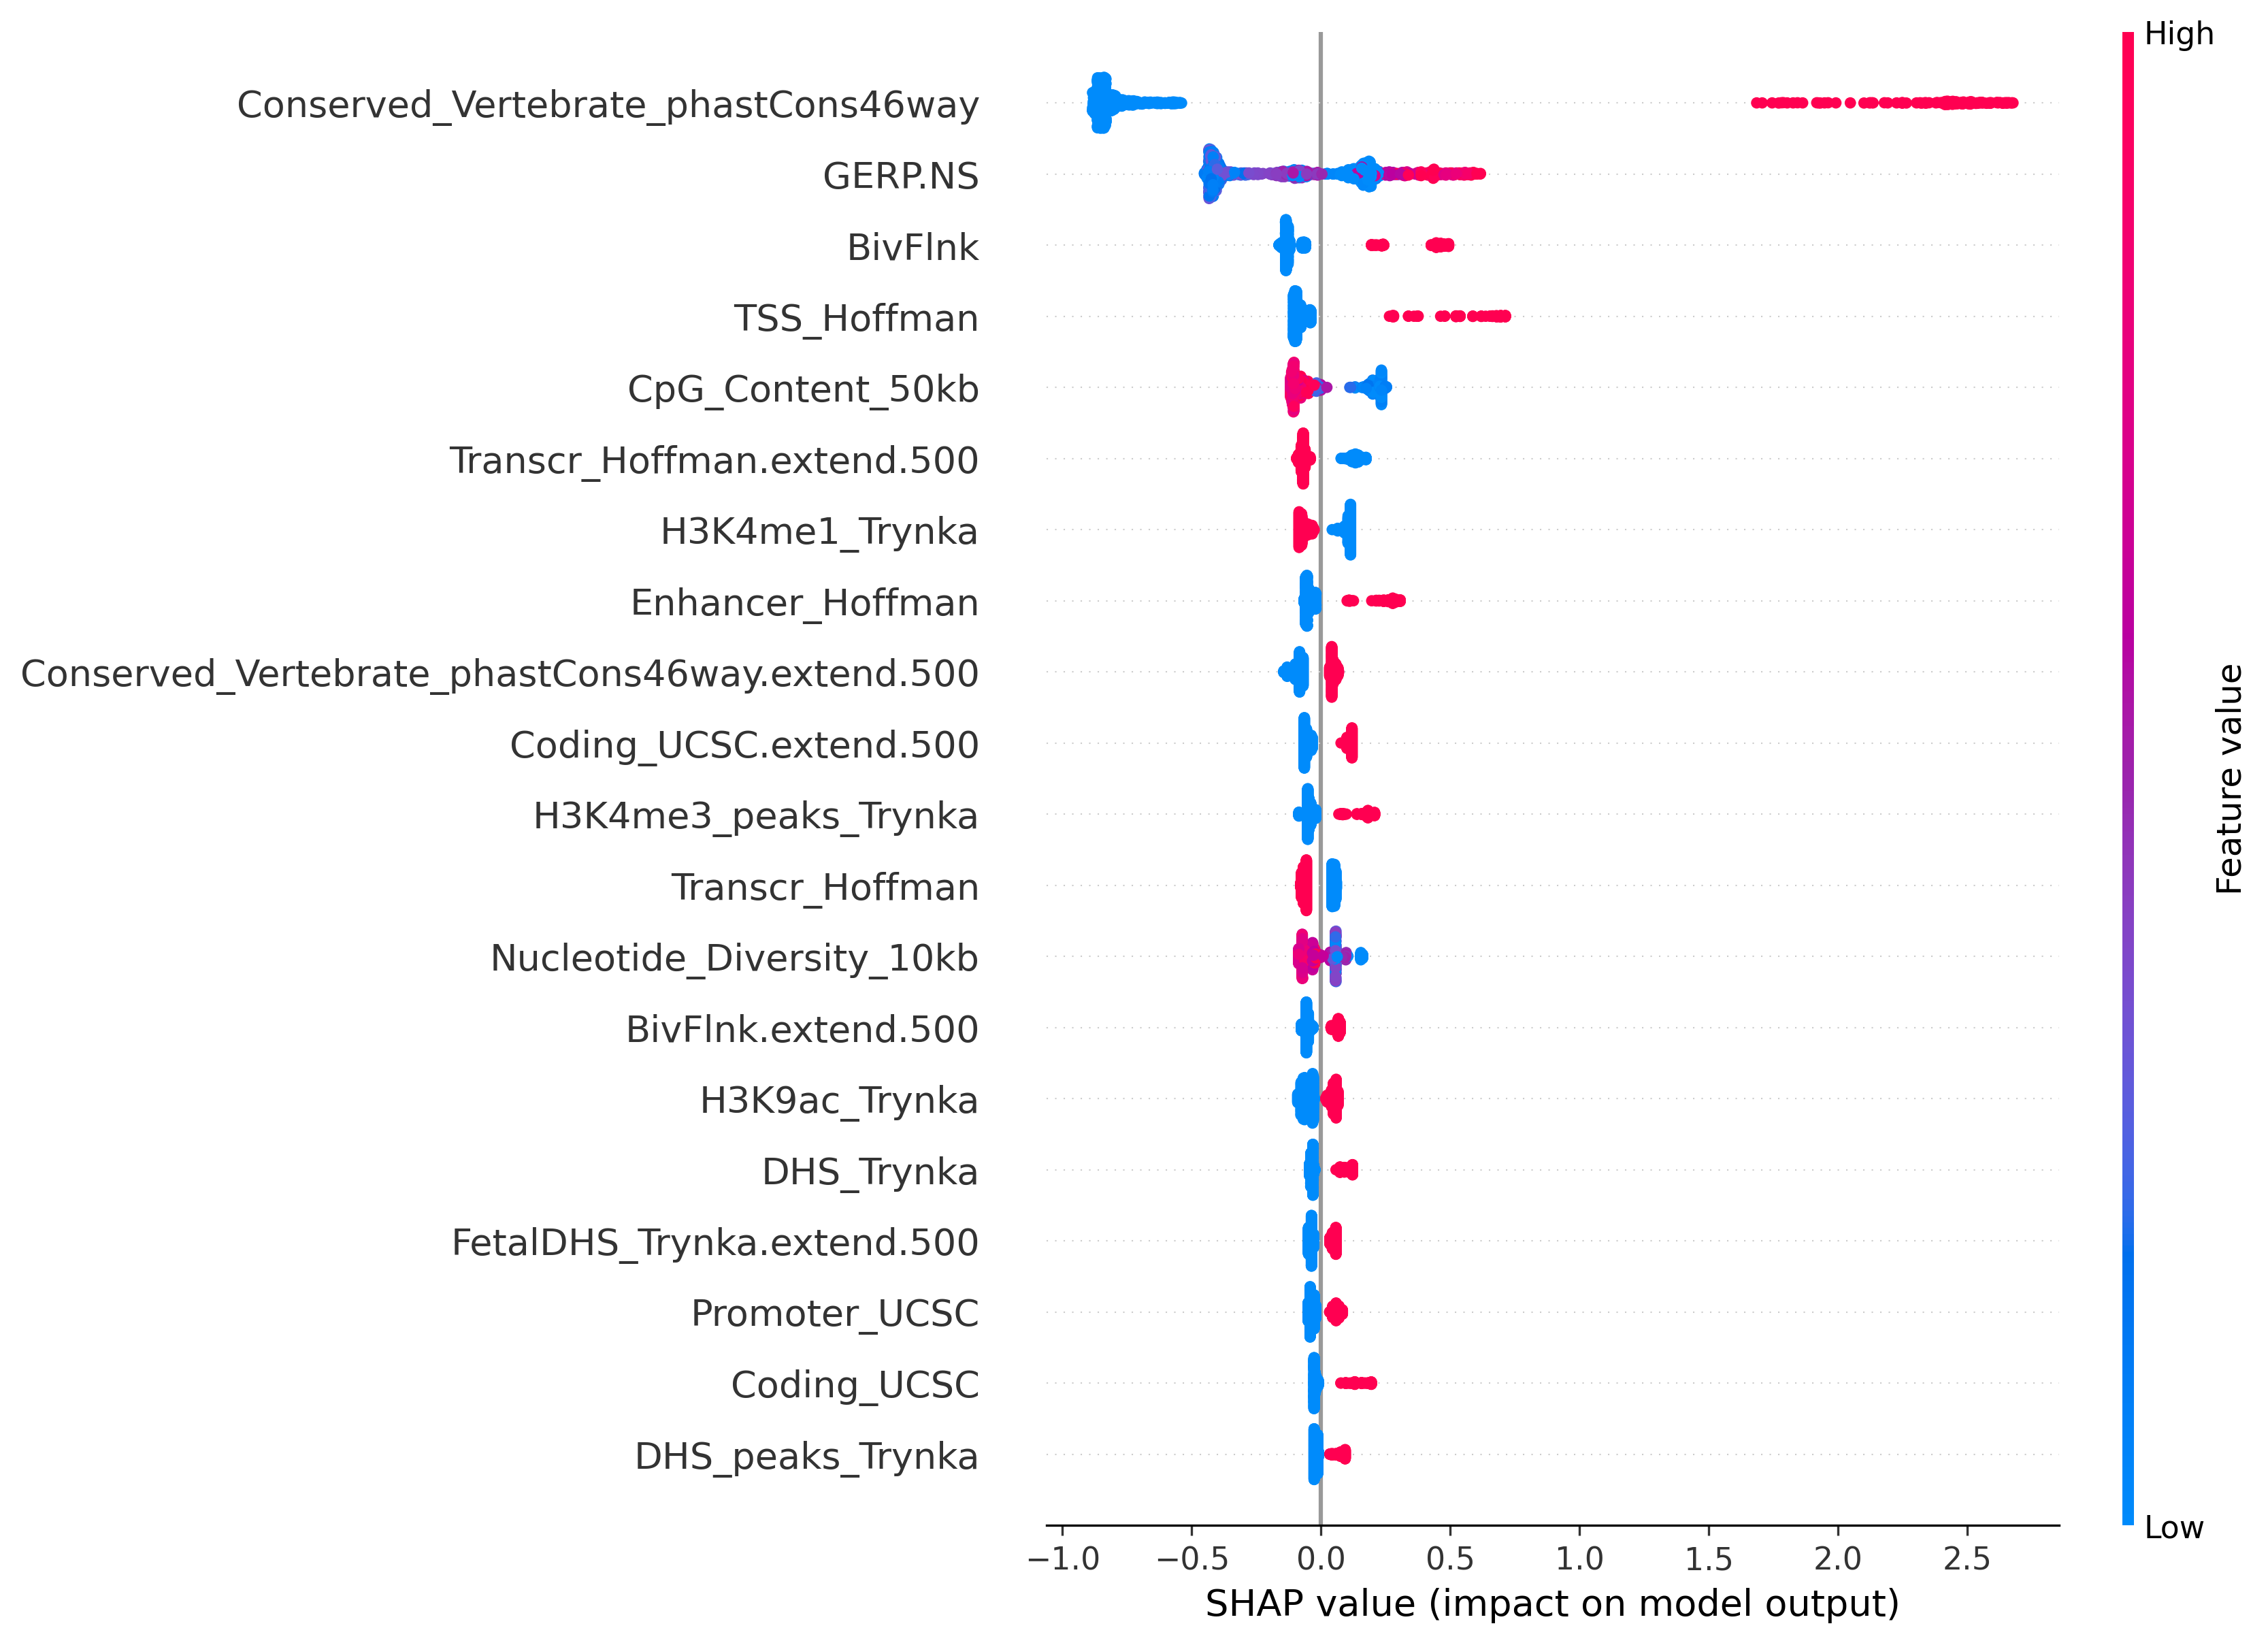

In [21]:
xgb_best
Image(filename='%s/SHAP_signedsummary_CADD_input.csv.gz_odd.png' %args.basedir) 

In [22]:
#training even/odd chr model completed!
#--mode 'applying'
with open("%s/%s:even.pickle" %(args.basedir, args.published_score_filename),'rb') as fp: 
	xgb_even = pickle.load(fp)
with open("%s/%s:odd.pickle" %(args.basedir, args.published_score_filename),'rb') as fp: 
	xgb_odd = pickle.load(fp)
print("reading even/odd chr trained model!...applying the model on the other chr SNPs")
all_df = pd.read_csv("%s/baselineLD_allchr.annot.gz" %args.basedir,sep="\t")
all_df = all_df.drop(["CM", "base"],axis=1)
score = pd.read_csv("%s/%s" %(args.basedir, args.published_score_filename))
rf = pd.read_csv("%s/1000G_final.vcf.gz" %args.basedir, names=["CHR","BP","SNP","REF","ALT"])
score = score.merge(rf, on=["CHR","BP","REF","ALT"]) #if window-based, remove REF, ALT here
score = score[["SCORE","SNP"]]
all_df = all_df.merge(score, how='left')
all_df["SCORE"] = all_df["SCORE"].fillna(0) #for ROC/PR curve purposes
all_df["Y"] = -1
all_df.loc[all_df.SNP.isin(score[score.SCORE >= score.SCORE.quantile(0.9)].SNP.to_list()), "Y"] = 1 #top 10% indicate as Y = 1
all_df.loc[all_df.SNP.isin(score[score.SCORE < score.SCORE.quantile(0.4)].SNP.to_list()), "Y"] = 0 #bottom 40% indicate as Y = 0
all_df.head(5)

reading even/odd chr trained model!...applying the model on the other chr SNPs


,CHR,BP,SNP,Coding_UCSC,Coding_UCSC.extend.500,Conserved_LindbladToh,Conserved_LindbladToh.extend.500,CTCF_Hoffman,CTCF_Hoffman.extend.500,DGF_ENCODE,...,Conserved_Vertebrate_phastCons46way,Conserved_Vertebrate_phastCons46way.extend.500,Conserved_Mammal_phastCons46way,Conserved_Mammal_phastCons46way.extend.500,Conserved_Primate_phastCons46way,Conserved_Primate_phastCons46way.extend.500,BivFlnk,BivFlnk.extend.500,SCORE,Y
0,1,11008,rs575272151,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.205,-1
1,1,11012,rs544419019,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.205,-1
2,1,13110,rs540538026,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,4.850,-1
3,1,13116,rs62635286,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,2.185,-1
4,1,13118,rs200579949,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0.216,0


In [23]:
all_df_even = all_df[all_df.CHR % 2 == 0]
all_df_odd = all_df[all_df.CHR % 2 == 1]
print("applying even chr model on odd chr SNPs!")
odd_predicted = test_model(xgb_even, all_df_odd[features].values, all_df_odd["Y"].values, all_df_odd, "even")
print("applying odd chr model on even chr SNPs!")
even_predicted = test_model(xgb_odd, all_df_even[features].values, all_df_even["Y"].values, all_df_even, "odd")
all_df_odd["Boosted SCORE"] = odd_predicted
all_df_even["Boosted SCORE"] = even_predicted
all = all_df_odd.append(all_df_even)
all = all.drop(["Y"],axis=1)
print("predictions completed!") #final result df includes: 'CHR','BP','SNP', 85 features, SCORE (original input), Boosted SCORE
#all.to_csv("%s/RESULTwithfeatures_%s.csv.gz" %(args.basedir, args.published_score_filename.split(".csv.gz")[0]), compression='gzip', index=False)
all = all[["SNP","CHR","BP","SCORE","Boosted SCORE"]]	
all.to_csv("%s/RESULT_%s.csv.gz" %(args.basedir, args.published_score_filename.split(".csv.gz")[0]), compression='gzip', index=False)

applying even chr model on odd chr SNPs!
applying odd chr model on even chr SNPs!



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


predictions completed!


In [24]:
all.head(10)

,SNP,CHR,BP,SCORE,Boosted SCORE
0,rs575272151,1,11008,4.205,0.451085
1,rs544419019,1,11012,4.205,0.451085
2,rs540538026,1,13110,4.850,0.368259
3,rs62635286,1,13116,2.185,0.482796
4,rs200579949,1,13118,0.216,0.482796
5,rs531730856,1,13273,9.513,0.772531
6,rs554008981,1,13550,1.419,0.368259
7,rs546169444,1,14464,1.546,0.469255
8,rs531646671,1,14599,5.032,0.505487
9,rs541940975,1,14604,5.407,0.505487


Using odd chr model; tested on even chr SNPs


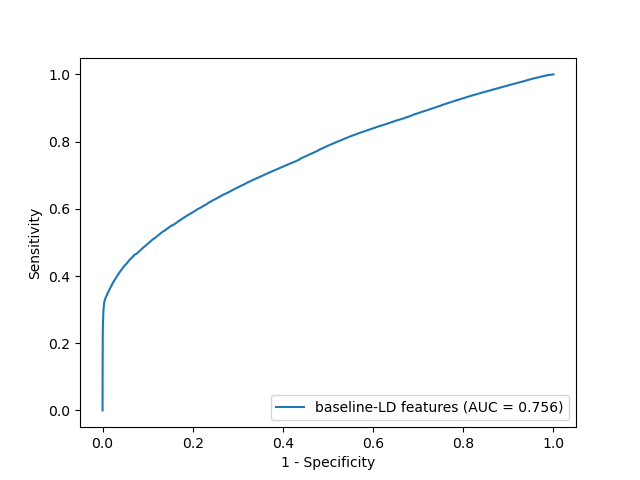

In [26]:
#out-of-chr AUROC/AUPRC on classifying top 10% vs. bottom 40% binarized pathogenicity labels
#AUROC/AURPC (Avg. Precision) does not inform the informativeness of the functional annotations.
#AUROC/AUPRC is used to evaluate how well baseline-LD features can predict the training labels
print("Using odd chr model; tested on even chr SNPs")
Image(filename='%s/ROC_CURVE_CADD_input.csv.gz_odd.png' %args.basedir) 

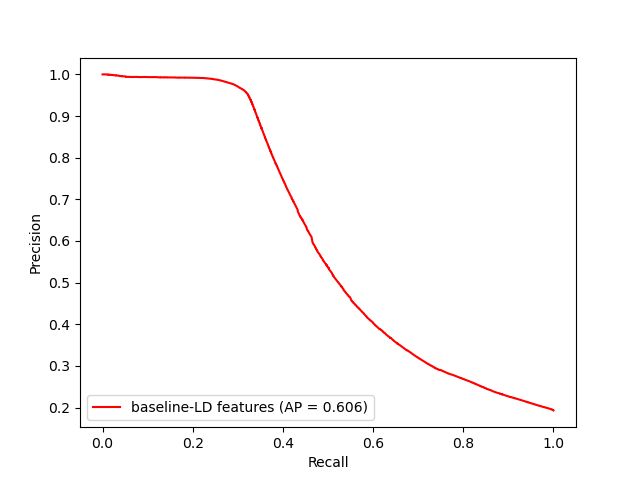

In [27]:
Image(filename='%s/PR_CURVE_CADD_input.csv.gz_odd.png' %args.basedir) 

Using even chr model; tested on odd chr SNPs


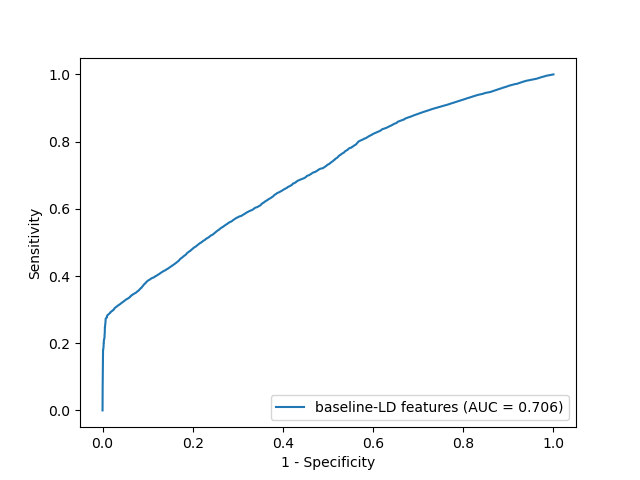

In [28]:
print("Using even chr model; tested on odd chr SNPs")
Image(filename='%s/ROC_CURVE_CADD_input.csv.gz_even.png' %args.basedir) 

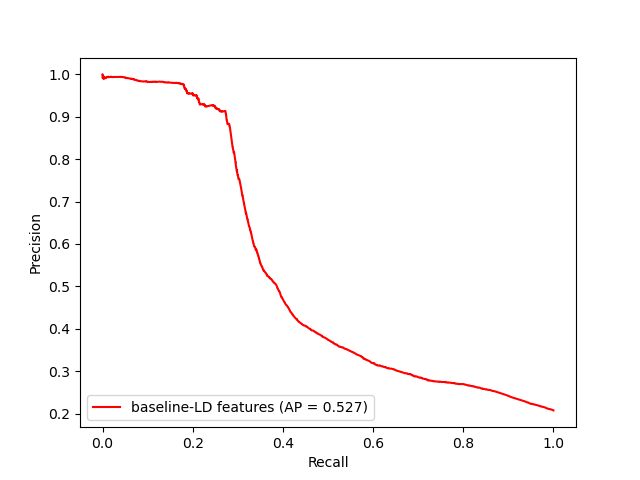

In [29]:
Image(filename='%s/PR_CURVE_CADD_input.csv.gz_even.png' %args.basedir) 

In [ ]:
#make annotations
prediction_to_annot(args.published_score_filename, "demo", "SCORE") #check the file name follows the convention used in this script
prediction_to_annot(args.published_score_filename, "demo", "Boosted SCORE")

In [ ]:
#check the output:(%s/demo_published.perc90.1.annot.gz) %args.basedir
#These .annot.gz can be directly used to run S-LDSC. These annotation files are baesd on 1000G EUR3 reference panel.
#See S-LDSC scripts: .annot.gz -> .l2.ldscore.gz -> .results -> meta-analysis across traits (https://github.com/samskim/networkconnectivity)
#If you want to use a different reference panel, change "1000G_final.vcf.gz"